changer Hide en une formulation plus claire.

In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import load_data_excel, convert_numeric_columns
from src.features import encode_categorical_feature, get_simplified_names
from src.experiments import (
    prepare_data_random_split, prepare_data_hide_one_per_class,
    prepare_data_hide_class, train_xgboost_models, get_hidden_products_info
)
from src.visu import plot_ml_results

# Load data
data = load_data_excel('../data/sources/Donnees_IA_2025.xlsx')

# Define variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut",
    "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut",
    "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut",
    "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

# Convert numeric columns
data = convert_numeric_columns(data, vars_expl + vars_cibles)

# Get simplified names
simplified_names = get_simplified_names()

print(f" Data loaded: {len(data)} observations")

 Data loaded: 6376 observations


## Out-Of-Distribution (OOD) Robustness Testing

Test model generalization by hiding products/classes during training and evaluating on held-out data.

### Baseline: In-Distribution Random Split (IID)

In [2]:
# IID Baseline
X_train_iid, X_test_iid, y_train_iid, y_test_iid = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

results_iid, metrics_iid, models_iid = train_xgboost_models(
    X_train_iid, X_test_iid, y_train_iid, y_test_iid,
    vars_cibles, simplified_names, random_state=42
)

print("\n" + "="*80)
print("BASELINE: In-Distribution (IID) Random Split")
print("="*80)
print(f"Train: {len(X_train_iid)}, Test: {len(X_test_iid)}")
print(f"R² variance weighted: {metrics_iid['R2_variance_weighted']:.4f}")
print(f"R² uniform: {metrics_iid['R2_uniform']:.4f}")


BASELINE: In-Distribution (IID) Random Split
Train: 5100, Test: 1276
R² variance weighted: 0.9899
R² uniform: 0.9903


### OOD Scenario 1: Hide 1 Random Product Per Class

In [3]:
# OOD Scenario 1: Hide 1 product per class
X_train_ood1, X_test_ood1, y_train_ood1, y_test_ood1, classe_test_ood1, nom_test_ood1 = \
    prepare_data_hide_one_per_class(data, vars_expl, vars_cibles, 'Classe', random_state=42)

results_ood1, metrics_ood1, models_ood1 = train_xgboost_models(
    X_train_ood1, X_test_ood1, y_train_ood1, y_test_ood1,
    vars_cibles, simplified_names, random_state=42
)

hidden_products = get_hidden_products_info(classe_test_ood1, nom_test_ood1)

print("\n" + "="*80)
print("OOD SCENARIO 1: Hide 1 Random Product Per Class")
print("="*80)
print(f"Train: {len(X_train_ood1)}, Test: {len(X_test_ood1)}")
print(f"R² variance weighted: {metrics_ood1['R2_variance_weighted']:.4f}")
print(f"\nPerformance drop vs IID: {metrics_ood1['R2_variance_weighted'] - metrics_iid['R2_variance_weighted']:+.4f}")
print("\nHidden products used for testing:")
print(hidden_products.to_string(index=False))


OOD SCENARIO 1: Hide 1 Random Product Per Class
Train: 5160, Test: 1216
R² variance weighted: 0.7695

Performance drop vs IID: -0.2204

Hidden products used for testing:
                                Classe                                          Nom
                              Céréales                                    Triticale
              Autres produits végétaux                  Farine de gousse de caroube
        Autres coproduits des céréales                    Coproduits de biscuiterie
                    Coproduits du maïs                               Germes de maïs
                     Coproduits du blé               Remoulage de blé tendre (tous)
        Farines et solubles de poisson                   Farine de poisson (toutes)
       Coproduits d'animaux terrestres                    Farine de viande (toutes)
Graines protéagineuses et oléagineuses                     Pois chiche, type Kabuli
                 Fourrages déshydratés                                Pai

### OOD Scenario 2: Hide Entire Class

In [4]:
# OOD Scenario 2: Hide entire class
X_train_ood2, X_test_ood2, y_train_ood2, y_test_ood2, classe_hidden = \
    prepare_data_hide_class(data, vars_expl, vars_cibles, 'Classe', random_state=42)

results_ood2, metrics_ood2, models_ood2 = train_xgboost_models(
    X_train_ood2, X_test_ood2, y_train_ood2, y_test_ood2,
    vars_cibles, simplified_names, random_state=42
)

print("\n" + "="*80)
print("OOD SCENARIO 2: Hide Entire Class")
print("="*80)
print(f"Hidden class: {classe_hidden}")
print(f"Train: {len(X_train_ood2)}, Test: {len(X_test_ood2)}")
print(f"R² variance weighted: {metrics_ood2['R2_variance_weighted']:.4f}")
print(f"\nPerformance drop vs IID: {metrics_ood2['R2_variance_weighted'] - metrics_iid['R2_variance_weighted']:+.4f}")
print(f"Performance drop vs OOD1: {metrics_ood2['R2_variance_weighted'] - metrics_ood1['R2_variance_weighted']:+.4f}")


OOD SCENARIO 2: Hide Entire Class
Hidden class: Céréales
Train: 5627, Test: 749
R² variance weighted: 0.6505

Performance drop vs IID: -0.3394
Performance drop vs OOD1: -0.1190


### OOD Performance Summary & Visualization

In [5]:
scenarios_data = [
    {"Scenario": "IID Baseline", "metrics": metrics_iid, "size": len(X_test_iid)},
    {"Scenario": "OOD: Hide 1 Product", "metrics": metrics_ood1, "size": len(X_test_ood1)},
    {"Scenario": "OOD: Hide Class", "metrics": metrics_ood2, "size": len(X_test_ood2)},
]

ood_comparison = pd.DataFrame([
    {
        'Scenario': s['Scenario'],
        'Test Size': s['size'],
        'R² Variance Weighted': s['metrics']['R2_variance_weighted'],
        'Performance Drop': s['metrics']['R2_variance_weighted'] - metrics_iid['R2_variance_weighted']
    } 
    for s in scenarios_data
])


OOD PERFORMANCE SUMMARY TABLE
           Scenario  Test Size  R² Variance Weighted  Performance Drop
       IID Baseline       1276                0.9899            0.0000
OOD: Hide 1 Product       1216                0.7695           -0.2204
    OOD: Hide Class        749                0.6505           -0.3394


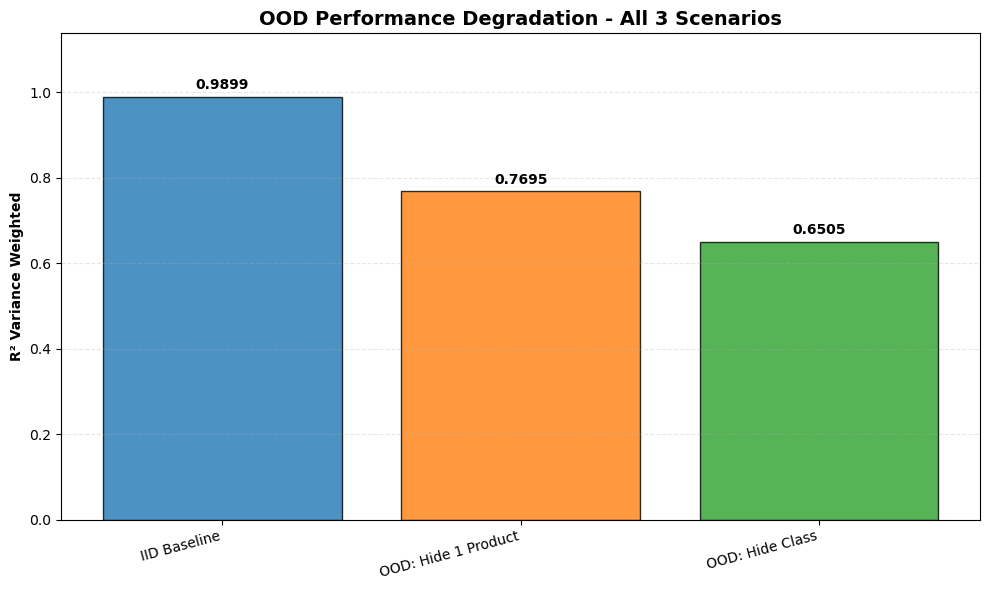

In [14]:
# Display OOD comparison
print("\n" + "="*80)
print("OOD PERFORMANCE SUMMARY TABLE")
print("="*80)
print(ood_comparison.to_string(index=False))

# OOD comparison visualization
fig = plot_ml_results(
    ood_comparison,
    x_col='Scenario',
    y_col='R² Variance Weighted',
    title='OOD Performance Degradation - All 3 Scenarios',
    figsize=(10, 6)
)
plt.show()

cross validation à faire

### OOD Scenario 3: Hide Specific Class (Parametric)
#### 'Autres produits végétaux'

In [7]:
# OOD Scenario 3: Hide specific class (parametric)
# User can specify which class to hide
available_classes = data['Classe'].unique()
print(f"Available classes: {list(available_classes)}")

# Choose a class to hide (different from Scenario 2)
class_to_hide_param = available_classes[1] if len(available_classes) > 1 else available_classes[0]

X_train_ood3, X_test_ood3, y_train_ood3, y_test_ood3, classe_hidden_param = \
    prepare_data_hide_class(data, vars_expl, vars_cibles, 'Classe', 
                           class_to_hide=class_to_hide_param, random_state=42)

results_ood3, metrics_ood3, models_ood3 = train_xgboost_models(
    X_train_ood3, X_test_ood3, y_train_ood3, y_test_ood3,
    vars_cibles, simplified_names, random_state=42
)

print("\n" + "="*80)
print(f"OOD SCENARIO 3: Hide Specific Class ('{classe_hidden_param}')")
print("="*80)
print(f"Train: {len(X_train_ood3)}, Test: {len(X_test_ood3)}")
print(f"R² variance weighted: {metrics_ood3['R2_variance_weighted']:.4f}")

Available classes: ['Céréales', 'Autres produits végétaux', 'Autres coproduits des céréales', 'Coproduits du maïs', 'Coproduits du blé', 'Farines et solubles de poisson', "Coproduits d'animaux terrestres", 'Graines protéagineuses et oléagineuses', 'Fourrages déshydratés', 'Amidon, racines et tubercules', 'Coproduits de fruits et légumes', "Tourteaux d'oléagineux", 'Coproduits du riz', 'Mélasses et vinasses', 'Produits laitiers']

OOD SCENARIO 3: Hide Specific Class ('Autres produits végétaux')
Train: 5936, Test: 440
R² variance weighted: 0.8197


#### 'Graines protéagineuses et oléagineuses'

In [17]:
# OOD Scenario 3: Hide specific class (parametric)
# User can specify which class to hide
available_classes = data['Classe'].unique()
print(f"Available classes: {list(available_classes)}")

# Choose a class to hide (different from Scenario 2)
class_to_hide_param = available_classes[7] if len(available_classes) > 1 else available_classes[0]

X_train_ood3, X_test_ood3, y_train_ood3, y_test_ood3, classe_hidden_param = \
    prepare_data_hide_class(data, vars_expl, vars_cibles, 'Classe', 
                           class_to_hide=class_to_hide_param, random_state=42)

results_ood3, metrics_ood3, models_ood3 = train_xgboost_models(
    X_train_ood3, X_test_ood3, y_train_ood3, y_test_ood3,
    vars_cibles, simplified_names, random_state=42
)

print("\n" + "="*80)
print(f"OOD SCENARIO 3: Hide Specific Class ('{classe_hidden_param}')")
print("="*80)
print(f"Train: {len(X_train_ood3)}, Test: {len(X_test_ood3)}")
print(f"R² variance weighted: {metrics_ood3['R2_variance_weighted']:.4f}")

Available classes: ['Céréales', 'Autres produits végétaux', 'Autres coproduits des céréales', 'Coproduits du maïs', 'Coproduits du blé', 'Farines et solubles de poisson', "Coproduits d'animaux terrestres", 'Graines protéagineuses et oléagineuses', 'Fourrages déshydratés', 'Amidon, racines et tubercules', 'Coproduits de fruits et légumes', "Tourteaux d'oléagineux", 'Coproduits du riz', 'Mélasses et vinasses', 'Produits laitiers']

OOD SCENARIO 3: Hide Specific Class ('Graines protéagineuses et oléagineuses')
Train: 5719, Test: 657
R² variance weighted: 0.5025


/home/alan/projects/projet_fil_rouge/Clean_repo/notebooks/../src/visu.py:482: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


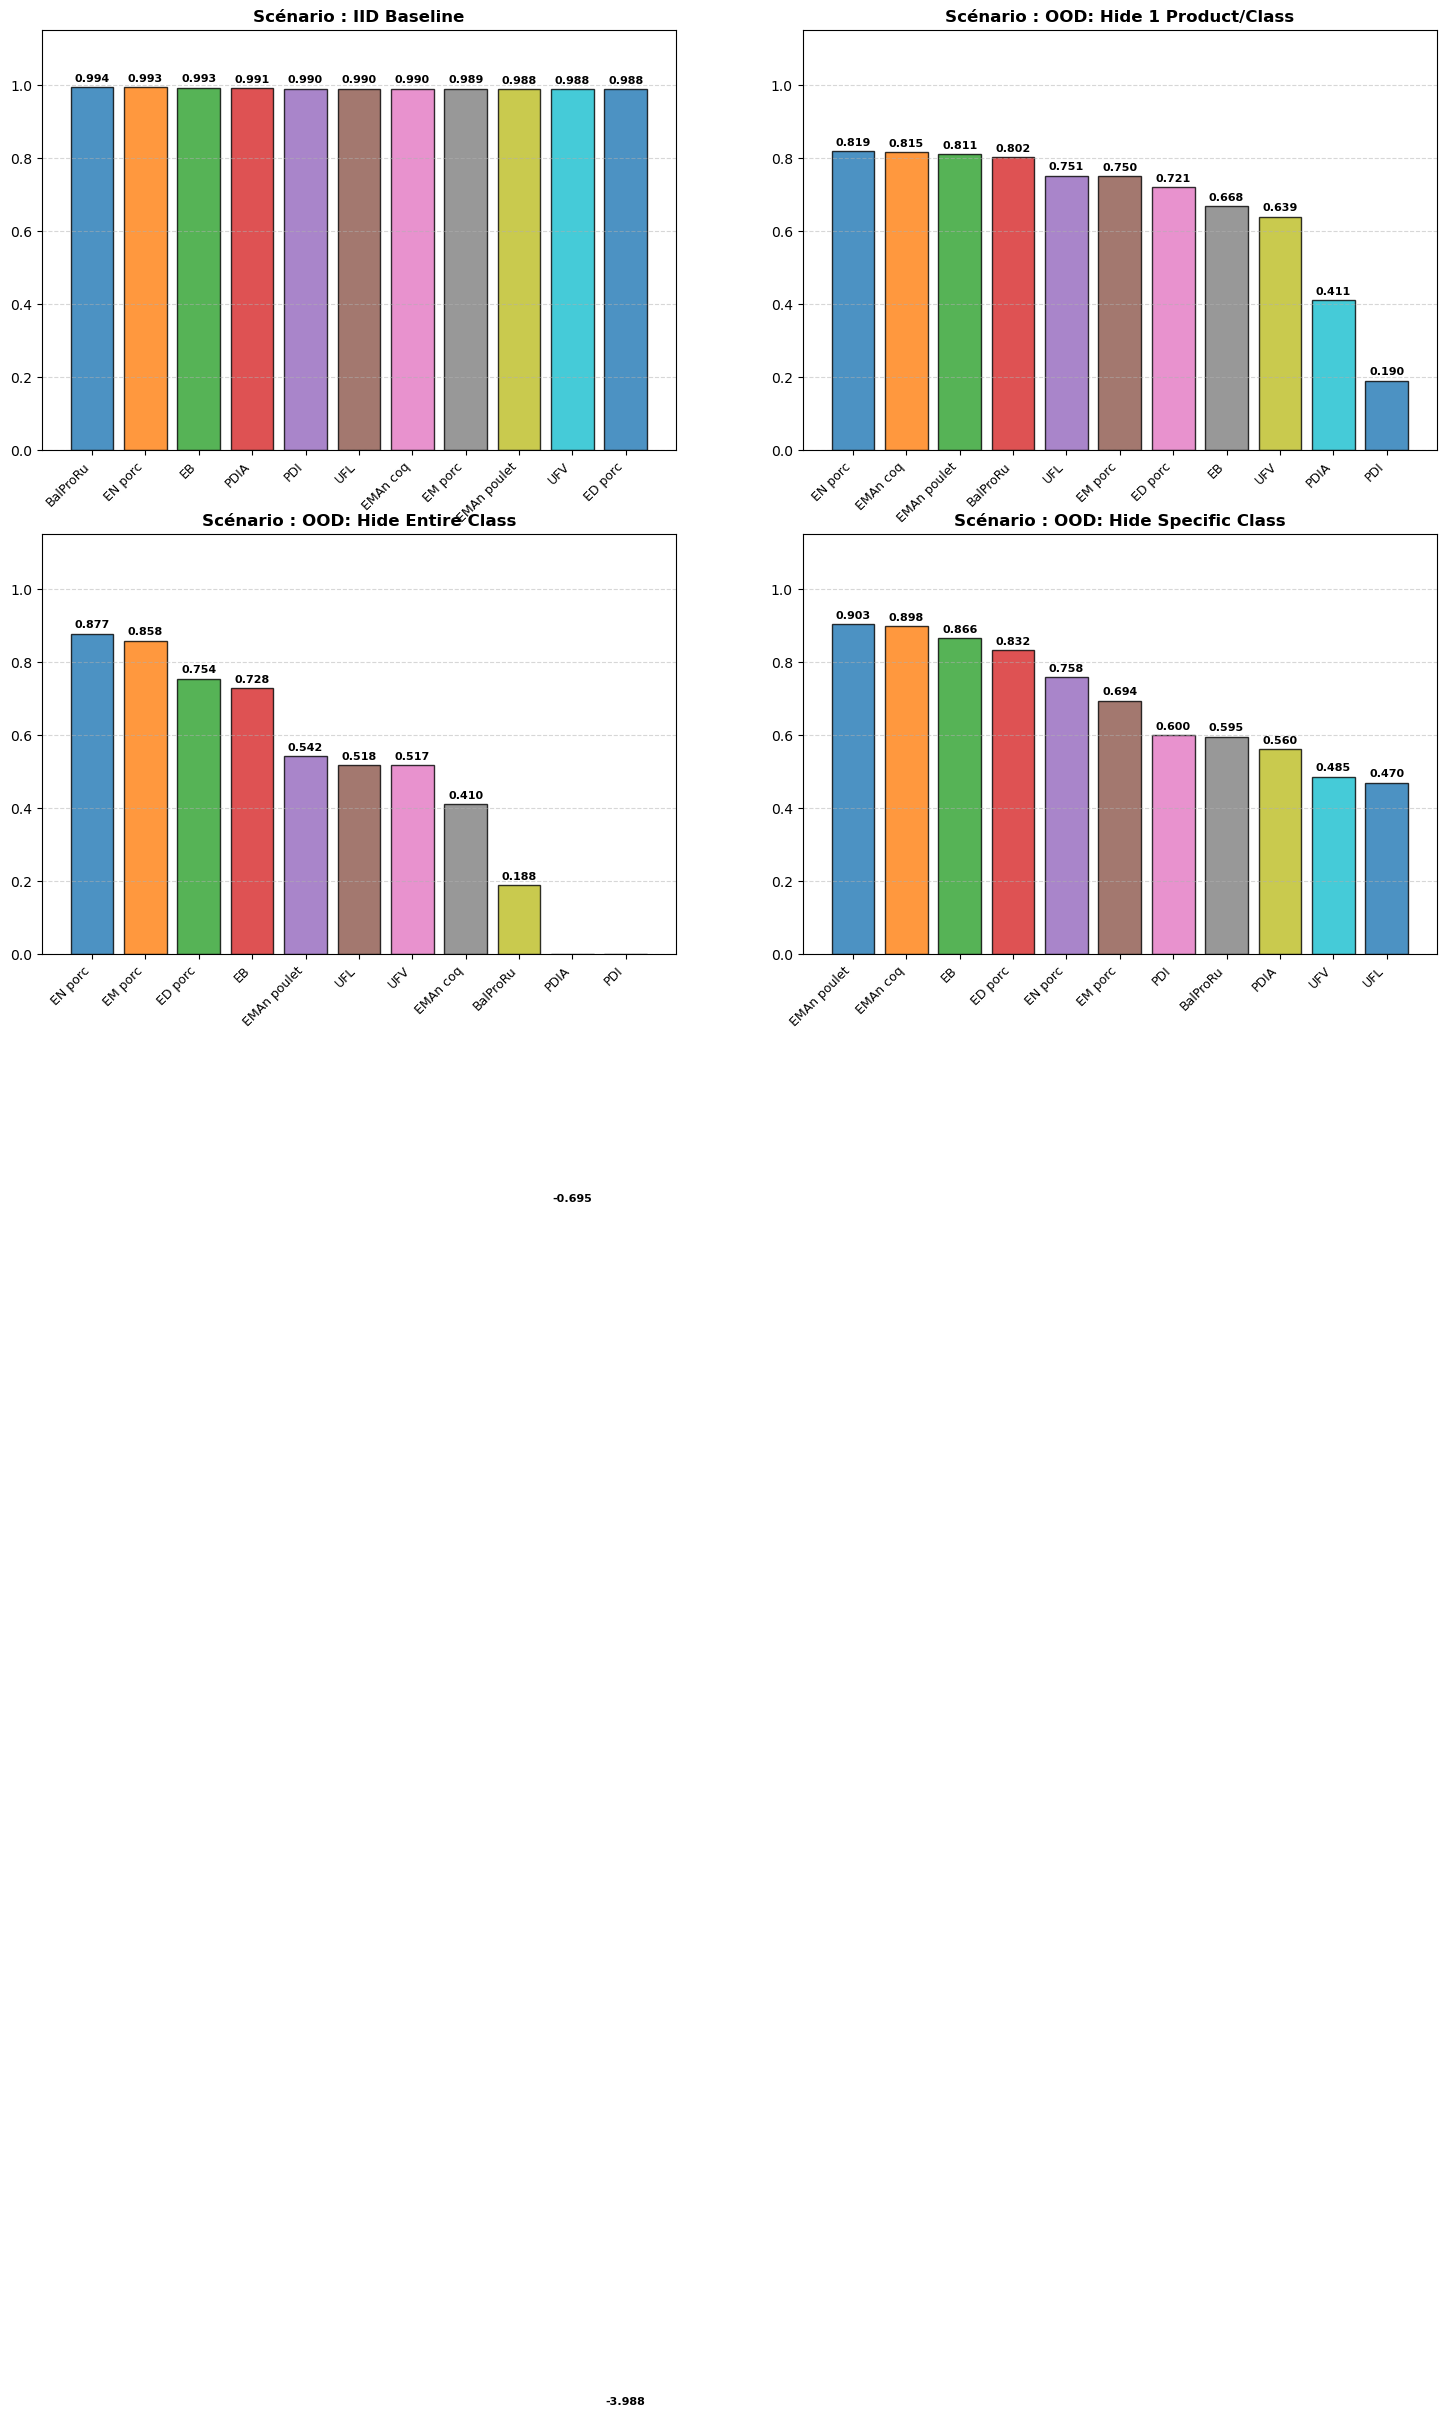

In [16]:
# Grid of R² by target variable for all OOD scenarios
all_ood_results = {
    'IID Baseline': results_iid,
    'OOD: Hide 1 Product/Class': results_ood1,
    'OOD: Hide Entire Class': results_ood2,
    'OOD: Hide Specific Class': results_ood3
}

fig = plot_ml_results(
    all_ood_results,
    y_col='R2',
    title='R² per Target Variable - All OOD Scenarios',
    figsize=(18, 12)
)
plt.show()